In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

from package.utils import KPIPoint
from package.utils import KPISet
from package.utils import Transformer
from package.HotSpot import HotSpot

#### 加载第1周数据

In [2]:
# timestamp_strat = 1535731200
# timestamp_end = 1536335700 #1535731200 + 5 * 60#
# timestamp_interval = 5 * 60
# file_path = '../2019AIOps_data/'
# kSet_train = Transformer().transformKPIData2KPISet(file_path, timestamp_strat, timestamp_end, timestamp_interval)
#kSet_train.save('../result/metadata/KPISetTrain')
kSet_train = KPISet({}, {})
kSet_train.load('../result/metadata/KPISetTrain') 

#### 加载第2周数据

In [3]:
# timestamp_strat = 1536336000
# timestamp_end = 1536940500 #1536336000 + 5 * 60# 
# timestamp_interval = 5 * 60
# file_path = '../2019AIOps_data/'
# kSet_valid = Transformer().transformKPIData2KPISet(file_path, timestamp_strat, timestamp_end, timestamp_interval)
# kSet_valid.save('../result/metadata/KPISetTrainValid')
kSet_valid = KPISet({}, {})
kSet_valid.load('../result/metadata/KPISetTrainValid') 

100%|██████████| 2016/2016 [41:39<00:00,  1.09s/it]


#### 使用第一周数据预测第二周数据，此处采用前一周7天同时间窗的KPI的均值作为预测值

In [14]:
# 使用第一周数据预测第二周数据
I = 300
T = I * 288 * 7
train_timestamp_start = 1535731200
train_timestamp_end = 1536335700
for timestamp in tqdm(kSet_valid._KPIPoints):
    tw = math.floor((timestamp - 16 * 3600) % (3600 * 24) / I)
    # print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(timestamp)), tw)
    for leaf in kSet_valid._KPIPoints[timestamp]._leaf:
        ts_true = kSet_train.get_ts_leaf(leaf=leaf, 
                                         t1=train_timestamp_start + tw * I,
                                         t2=train_timestamp_end, 
                                         delta=T)['true']
        predict = np.mean(ts_true)
        kSet_valid._KPIPoints[timestamp]._leaf[leaf][1] = predict

# 保存数据
kSet_valid.save('../result/metadata/KPISetValidPredict')

100%|██████████| 2016/2016 [02:26<00:00, 15.06it/s]


#### 计算MAE

In [17]:
mae = 0
count = 0
maeList = []
real = []
pred = []
kSet_valid = KPISet({},{})
kSet_valid.load('../result/metadata/KPISetValidPredict2')
for ts in kSet_valid._KPIPoints:
    for leaf in kSet_valid._KPIPoints[ts]._leaf:
        value = kSet_valid._KPIPoints[ts]._leaf[leaf]
        mae += abs(value[0] - value[1])
        maeList.append(mae)
        real.append(value[0])
        pred.append(value[1])
        count += 1
print(len(maeList))
print('MAE = %f' % (mae / count))

4904304
MAE = 123.788527


MAE 123.788527034


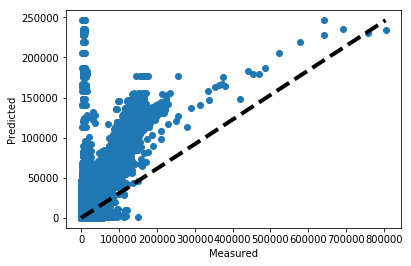

In [20]:
evaluate(real, pred, 'MAE')
visualize(real, pred)